In [1]:
from bs4 import BeautifulSoup
import re
import os
from tqdm import tqdm
from collections import Counter
import torch
import time
import multiprocessing
import gensim
import pymorphy2
import numpy as np

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [3]:
proj_types, proj_names, proj_descrs = [],[],[]
folders = os.listdir('texts')
for folder in tqdm(folders):
    f = open(f"texts/{folder}/choose", "r", encoding="utf-8")
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')
    founded = soup.find_all('div', {'class': 'lr-project-value'})
    proj_types.append( re.sub(r'[\n\t]', '', founded[1].get_text().lower()) )
    proj_names.append( re.sub(r'[\n\t]', '', founded[3].get_text().lower()) )
    proj_descrs.append( re.sub(r'[\n\t]', '', founded[4].get_text().lower()) )
    f.close()
    


100%|██████████| 6605/6605 [00:33<00:00, 197.54it/s]


In [4]:
from collections import defaultdict

In [5]:
types_dict = defaultdict(int)
for proj_type in (proj_types):
    types_dict[proj_type] += 1
    
for key, value in sorted(types_dict.items(), key=lambda item: item[1], reverse = True):
    print("%s: %s" % (key, value))

другое: 2206
просвещение и образование — новые форматы и темы: 1851
зож: профилактика, а не лечение: 570
семья: сохранение традиций и ценностей: 533
искусственный интеллект и современные технологии на службе обществу: 523
75-я годовщина со дня победы в великой отечественной войне: 308
правовая защита граждан и предпринимателей: 216
проекты в области науки: 159
внутренний туризм: новые формы, новые маршруты: 157
культурно-историческое наследие россии: 82


In [6]:
topic = 'просвещение и образование — новые форматы и темы'

In [7]:
names, descrs = [], []
for i in range( len(proj_names) ):
    if proj_types[i] == topic:
        names.append( proj_names[i] )
        descrs.append( proj_descrs[i] )

In [8]:
len(names)

1851

In [9]:
for i in range( len(proj_descrs) ):
    if proj_descrs[i].find("в наши дни тема финансов") > -1:
        print (proj_descrs[i])

в наши дни тема финансов крайне актуальна. каждый день мы сталкиваемся с денежными средствами: магазины, банки, транспорт и т.д прививать "правила обращения с деньгами• и финансовую грамотность в современном обществе необходимо с раннего возраста.для детей младшего школьного возраста необходимо провести урок на тему  "финансовая грамотность". суть урока состоит в том, чтобы объяснить детям: что такое деньги, для чего они нужны, правила обращения с деньгами в повседневной жизни. а также показать способы накоплений, рациональных трат, последствия растрачивания денег.урок рассчитан для учащихся 3-5  классов - проводится в игровой формея рассчитываю на то, что после такого урока детям станет интересна эта тема и они смогут использовать полученные знания и идеи вместе с родителями на практике.


In [10]:
proj_descrs[31]

'с целью благоустройства территории г. тулы планируется определить участки наиболее нуждающиеся в благоустроительных работах. будут проведены мероприятия по очистке территорий от мусора, установки малых форм (урны). планируется привлечь к данным мероприятиям школьников, общественные молодёжные организации. в весенний период будут проведены посадки саженцев деревьев и кустарников с целью озеленение города.'

In [11]:
# process text
for i in range( len(names) ):
    ### NAMES
    # lowcase, no , - : ; ( ) " ' « » and .
    #line = names[i].lower()
    line = names[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\.\!\?\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to space
    line = re.sub(r'\.+', ' ', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    #line = re.sub(r'\. ', '.', line)
    names[i] = line.strip()
    
    ### DESCRS
    # lowcase, no , - : ; ( ) " ' « » keep .
    #line = descrs[i].lower()
    line = descrs[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    # ё -> е
    line = re.sub(r'ё', 'е', line)
    # ! > .
    line = re.sub(r'[\!\?]', ".", line)
    # remove all digits and symbols connected to words
    line = re.sub(r'([а-яА-Яa-zA-Z])([\d\:\*]+)', r'\1', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    line = re.sub(r'\. ', '.', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    descrs[i] = line.strip()

In [12]:
names[0]

'на базе районного клуба культуры организовать курсы и индивидуальные занятия по использованию современных цифровых технологий для пожилых людей'

In [13]:
descrs[0]

'целью проекта является создание условий для социальной адаптации пожилых людей к использованию современных цифровых технологий улучшение качества их жизни.основные направления обучения получение государственных услуг в электронном виде социальные сети и мессенджеры для общения с близкими использование электронной почты поиск новостного и мультимедийного контента информационная безопасность правила поведения в сети интернет.обучение будет иметь в большей степени практический уклон.проект планируется осуществить на базе районных учреждений культуры.по словам сотрудников нашего районного клуба не все пожилые люди успешно воспринимают существующие курсы компьютерной грамотности им не хватает практических занятий и индивидуального подхода а также умений пользоваться другими гаджетами смартфонами планшетами современными телевизорами.часто требуется помощь по настройке устройств.руководство клуба известит пожилых людей района и соберет заявки желающих.планирую создать учебный план печатные м

### Пробуем просто все предложения данной тематике собрать в кучу

In [14]:
all_sents = []
max_slen = 0
for i in range(len(descrs)):
    sents = descrs[i].split('.')
    for j in range(len(sents)):
        sents[j] = sents[j].strip()
        slen = len(sents[j])
        if slen > 0:
            all_sents.append(sents[j])

In [15]:
len(all_sents)

31656

In [16]:
all_sents[1]

'основные направления обучения получение государственных услуг в электронном виде социальные сети и мессенджеры для общения с близкими использование электронной почты поиск новостного и мультимедийного контента информационная безопасность правила поведения в сети интернет'

In [17]:
text = ' '.join(all_sents)
text = re.sub(r'  ', ' ', text)  # убрать двойные пробелы
ALL_WORDS = set(text.strip().split(' '))
len(ALL_WORDS)

43768

In [18]:
c = Counter(text.split(' '))
c.most_common(10)

[('и', 21758),
 ('в', 18693),
 ('на', 7544),
 ('с', 6533),
 ('для', 5374),
 ('по', 4119),
 ('не', 3525),
 ('проекта', 3469),
 ('к', 3143),
 ('как', 2428)]

In [19]:
# удаляем слова с числом повторений меньше 2
todelete = set()
for i, n in c.items():
    if n < 2:
        todelete.add(i)
        
for i in todelete:
    del c[i]

In [20]:
len(c.keys())

22050

In [21]:
all_sents[0]

'целью проекта является создание условий для социальной адаптации пожилых людей к использованию современных цифровых технологий улучшение качества их жизни'

In [23]:
# # сохраняем all_sents на посмотреть
# f = open('all_sents_22k.txt', 'w')
# for i in range(len(all_sents)):
#     f.write(all_sents[i] + "\n")
# f.close()


In [28]:
# обучаем w2v
# model_w2v = gensim.models.KeyedVectors.load_word2vec_format('embed_models/183 - ruwikiruscorpora-func_upos_skipgram_300_5_2019/model.bin', binary=True)
# model_w2v_weights = torch.FloatTensor(model_w2v.vectors).to(dev)
# %%time
cores = multiprocessing.cpu_count()
model_w2v = gensim.models.Word2Vec(min_count=2, size=300, window=5, workers=cores-1)

t = time.time()
model_w2v.build_vocab(all_sents, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

#model_w2v_weights = torch.FloatTensor(model_w2v.vectors).to(dev)

Time to build vocab: 0.01 mins


In [29]:
t = time.time()
model_w2v.train(all_sents, total_examples=model_w2v.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.3 mins


In [30]:
model_w2v.init_sims(replace=True)

In [31]:
#weights = torch.FloatTensor(model.vectors) # formerly syn0, which is soon deprecated
EMBED_SIZE = model_w2v.vector_size
EMBED_SIZE

300

In [32]:
WORDS_COUNT = len(c.keys())
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)
len(INDEX_TO_WORD)

22052

In [34]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'учись',
 'самопроверки',
 'используя',
 'iii',
 'профессионалами',
 'думе',
 'трендом',
 'оснащенности']

In [35]:
# create word_index to embedding array
index_to_embedding = torch.zeros([len(INDEX_TO_WORD), EMBED_SIZE], dtype=torch.float32)
cotags = {'ADJF':'ADJ', # pymorphy2: word2vec 
'ADJS' : 'ADJ', 
'ADVB' : 'ADV', 
'COMP' : 'ADV', 
'GRND' : 'VERB', 
'INFN' : 'VERB', 
'NOUN' : 'NOUN', 
'PRED' : 'ADV', 
'PRTF' : 'ADJ', 
'PRTS' : 'VERB', 
'VERB' : 'VERB',
# my
'CONJ' : 'ADV',
'INTJ' : 'NOUN',
'PREP' : 'PROPN',
'NUMR' : 'NUM',
'PRCL' : 'PROPN',
'NPRO' : 'PRON'
         }

In [36]:
morph = pymorphy2.MorphAnalyzer()
PAD_WORD = 'сингулярность'
MISS_WORD = 'хрень'
#index_to_embedding[0] = torch.from_numpy( model_w2v[PAD_WORD+"_NOUN"] )
index_to_embedding[0] = torch.zeros(EMBED_SIZE)
#index_to_embedding[1] = torch.from_numpy( model_w2v[MISS_WORD+"_NOUN"] )
index_to_embedding[1] = torch.ones(EMBED_SIZE)

cnotfound_in_pymorphy = 0
cnotfound_in_w2v = 0
not_found_in_pymorphy = []
not_found_in_w2v = []

for i in tqdm( range(2,len(INDEX_TO_WORD)) ):
    word = INDEX_TO_WORD[i]
    #print (word)
    info = morph.parse(word)[0]
    if ('UNKN' in info.tag) or ('LATN' in info.tag) or ('NUMB' in info.tag) or ('PNCT' in info.tag) or ('ROMN' in info.tag):
        info = morph.parse(MISS_WORD)[0]
        cnotfound_in_pymorphy += 1
        not_found_in_pymorphy.append(word)
        
    p_speech = cotags[info.tag.POS]
    w2v_form = info.normal_form + "_" + p_speech
    
#     #debug
#     if w2v_form.startswith('касаться'):
#         print (morph.parse(word))
    
    if w2v_form in model_w2v:
        index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
    else:
        if p_speech == 'ADV':
            p_speech = 'ADJ'
            w2v_form = info.normal_form + "_" + p_speech
            if w2v_form in model_w2v:
                index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
            else:
                cnotfound_in_w2v += 1
                not_found_in_w2v.append(w2v_form)
                index_to_embedding[i] = index_to_embedding[1]  # MISS_WORD
        else:
            if p_speech == 'ADJ':
                p_speech = 'ADV'
                w2v_form = info.normal_form + "_" + p_speech
                if w2v_form in model_w2v:
                    index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
                else:
                    cnotfound_in_w2v += 1
                    not_found_in_w2v.append(w2v_form)
                    index_to_embedding[i] = index_to_embedding[1]  # MISS_WORD

print (f'Not found pmorphy2: {cnotfound_in_pymorphy}, not found in w2v: {cnotfound_in_w2v}')

  0%|          | 0/22050 [00:00<?, ?it/s]/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
100%|██████████| 22050/22050 [00:02<00:00, 7745.09it/s]

Not found pmorphy2: 665, not found in w2v: 7641


In [37]:
not_found_in_w2v[0:10]

['ваш_ADV',
 'льготный_ADV',
 'координационный_ADV',
 'этот_ADV',
 'интегрировать_ADV',
 'важный_ADV',
 'добавить_ADV',
 'информационный_ADV',
 'полезный_ADV',
 'целиком_ADJ']

In [47]:
word_form = model_w2v.wv.similar_by_vector( index_to_embedding[12].numpy(), 1)[0][0]
word = re.sub(r'([а-яА-Яa-zA-Z])_(.+)', r'\1', word_form)
word

' '

In [48]:
INDEX_TO_WORD[12]

'дал'

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([8.039e+03, 7.068e+03, 6.298e+03, 4.411e+03, 2.430e+03, 1.376e+03,
        7.910e+02, 4.350e+02, 2.550e+02, 1.670e+02, 1.070e+02, 6.300e+01,
        4.900e+01, 3.500e+01, 2.700e+01, 2.100e+01, 1.500e+01, 6.000e+00,
        5.000e+00, 1.300e+01, 8.000e+00, 5.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   6.98,  12.96,  18.94,  24.92,  30.9 ,  36.88,  42.86,
         48.84,  54.82,  60.8 ,  66.78,  72.76,  78.74,  84.72,  90.7 ,
         96.68, 102.66, 108.64, 114.62, 120.6 , 126.58, 132.56, 138.54,
        144.52, 150.5 , 156.48, 162.46, 168.44, 174.42, 180.4 , 186.38,
        192.36, 198.34, 204.32, 210.3 , 216.28, 222.26, 228.24, 234.22,
        240.2 , 

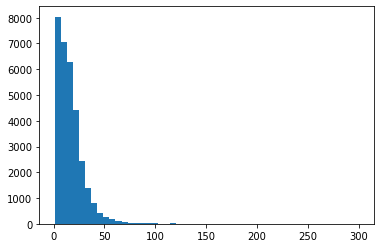

In [31]:
# распреление длины слов в предложении
plt.hist([len(s.split(' ')) for s in all_sents], bins=50)

In [32]:
MAX_LEN = 40

In [71]:
type(WORD_TO_INDEX)

dict

In [ ]:
# распределение количества слов в тексте

(array([3.840e+02, 9.550e+02, 1.083e+03, 8.000e+02, 6.300e+02, 5.200e+02,
        4.260e+02, 3.430e+02, 2.510e+02, 1.930e+02, 1.800e+02, 1.610e+02,
        1.010e+02, 7.600e+01, 8.200e+01, 5.100e+01, 5.900e+01, 3.900e+01,
        2.800e+01, 3.700e+01, 2.200e+01, 2.000e+01, 3.100e+01, 2.100e+01,
        1.800e+01, 2.200e+01, 1.900e+01, 1.900e+01, 1.600e+01, 2.000e+00,
        7.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([   4. ,   48.4,   92.8,  137.2,  181.6,  226. ,  270.4,  314.8,
         359.2,  403.6,  448. ,  492.4,  536.8,  581.2,  625.6,  670. ,
         714.4,  758.8,  803.2,  847.6,  892. ,  936.4,  980.8, 1025.2,
        1069.6, 1114. , 1158.4, 1202.8, 1247.2, 1291.6, 1336. , 1380.4,
        1424.8, 1469.2, 1513.6, 1558. , 1602.4, 1646.8, 1691.2, 1735.6,
        1780. , 

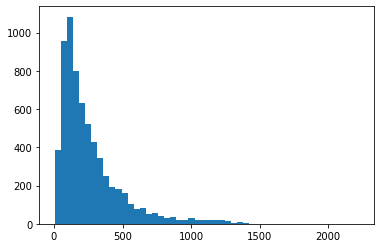

In [38]:
#len(proj_descrs[0].split(" "))
plt.hist([len(s.split(' ')) for s in proj_descrs], bins=50)

In [72]:
X = torch.zeros((len(all_sents), MAX_LEN, EMBED_SIZE), dtype=torch.float32)
# готовим матрицу - строка - предложение, столбец - эмбеддинг слова в этой позиции
for i in tqdm(range(len(all_sents))):
    for j, w in enumerate(all_sents[i].split(' ')):
        if j >= MAX_LEN:
            break
        X[i, j, 0:EMBED_SIZE] = index_to_embedding[ WORD_TO_INDEX.get(w, 1) ]
        
X = X.to(dev)

100%|██████████| 31656/31656 [00:03<00:00, 8587.04it/s]


In [73]:
X.shape

torch.Size([31656, 40, 300])

In [74]:
BATCH_SIZE = 10

In [75]:
class Network(torch.nn.Module):

    def __init__(self, dev, model_w2v_weights):
        super(Network, self).__init__()
        self.dev = dev
        #self.word_embeddings = torch.nn.Embedding.from_pretrained(model_w2v_weights).to(self.dev)
        self.gru = torch.nn.LSTM(EMBED_SIZE, EMBED_SIZE, num_layers = 3, batch_first=True).to(self.dev)
        #self.hidden2tag = torch.nn.Linear(128, len(INDEX_TO_WORD)).to(self.dev)
        
    def get_embeddings(self,sentences):
        csentences = sentences.size()[0]
        cwords = sentences.size()[1]
        embeds = torch.zeros(csentences, cwords, EMBED_SIZE).to(self.dev)
        for i in range(csentences):  
            for k in range(cwords):
                if sentences[i][k] == 0:
                    embeds[i][k] = self.word_embeddings[0]
                    break
                embeds[i][k] = torch.FloatTensor ([ emb for emb in self.word_embeddings[ sentences[i][k] ] ])
        return embeds

    def forward(self, sentences):
        #embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(sentences)
        #tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        tag_space = gru_out
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state
    
    def forward_state(self, sentences, state):
        #embeds = self.get_embeddings(sentences)
        #embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(sentences, state)
        #tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        tag_space = gru_out
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [76]:
model = Network(dev, model_w2v_weights)
model.forward(X[0:1])[0].shape

torch.Size([1, 40, 300])

In [77]:
def generate_sentence(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    X = torch.zeros((1, MAX_LEN, EMBED_SIZE), dtype=torch.float32).to(dev)
    for i in range(MAX_LEN):
        #X = torch.Tensor([[WORD_TO_INDEX[sentence[i]]]]).type(torch.long)
        #X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        X[0, i, 0:EMBED_SIZE] = index_to_embedding[ WORD_TO_INDEX.get(sentence[i], 1) ]
        #get(w, WORD_TO_INDEX['<miss>']
        #X = X.to(dev)
        if i == 0:
            result, state = model.forward(X)
        else:
            result, state = model.forward_state(X, state)
        prediction = result[0, -1, :].to('cpu')
        #index_of_prediction = prediction.argmax()
#         if i >= len(sentence) - 1:
#             if index_of_prediction == 0:
#                 break

        word_form = model_w2v.similar_by_vector(prediction.detach().numpy(), 1)[0][0]
        word = re.sub(r'([а-яА-Яa-zA-Z])_(.+)', r'\1', word_form)
        sentence.append(word)
        
    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)

In [78]:
lrate = 0.1

criterion = torch.nn.CosineEmbeddingLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrate)
#optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

In [79]:
generate_sentence('проект направлена на')

проект направлена на дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария дендрария


In [80]:
count = 0
target = torch.ones(EMBED_SIZE).to(dev)

for ep in range(2000):
    
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / BATCH_SIZE)):
        batch = X[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        X_batch = batch[:, :-1]
        #Y_batch = batch[:, 1:].flatten()
        Y_batch = batch[:, 1:]

        optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        #answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
    end = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, end - start, trloss))
        #generate_sentence('проект позволяет')

Epoch 0. Time: 17.745, Train loss: 0.782
Epoch 1. Time: 17.728, Train loss: 0.743
Epoch 2. Time: 17.791, Train loss: 0.733
Epoch 3. Time: 17.765, Train loss: 0.727
Epoch 4. Time: 17.765, Train loss: 0.722
Epoch 5. Time: 17.774, Train loss: 0.719
Epoch 6. Time: 17.748, Train loss: 0.715
Epoch 7. Time: 17.758, Train loss: 0.712
Epoch 8. Time: 17.729, Train loss: 0.710
Epoch 9. Time: 17.723, Train loss: 0.708
Epoch 10. Time: 17.733, Train loss: 0.707
Epoch 11. Time: 17.710, Train loss: 0.705
Epoch 12. Time: 17.641, Train loss: 0.703
Epoch 13. Time: 17.716, Train loss: 0.702
Epoch 14. Time: 17.724, Train loss: 0.701
Epoch 15. Time: 17.739, Train loss: 0.699
Epoch 16. Time: 17.745, Train loss: 0.698
Epoch 17. Time: 17.729, Train loss: 0.697
Epoch 18. Time: 17.745, Train loss: 0.696
Epoch 19. Time: 17.739, Train loss: 0.694
Epoch 20. Time: 17.708, Train loss: 0.693
Epoch 21. Time: 17.720, Train loss: 0.692
Epoch 22. Time: 17.774, Train loss: 0.691
Epoch 23. Time: 17.713, Train loss: 0.690
Ep

KeyboardInterrupt: 

In [1]:
generate_sentence('предлагается')

NameError: name 'generate_sentence' is not defined

In [ ]:
generate_sentence('проект позволяет')

In [ ]:
generate_sentence('в нашей стране дети')

In [112]:
generate_sentence('низкий уровень образования')

низкий уровень образования соединять соединять соединять соединять алабамский соединять соединять соединять алабамский алабамский алабамский доме доме доме пикетный пикетный пикетный пикетный пикетный пикетный панкратьев кпб габит взаимодополнять взаимодополнять взаимодополнять взаимодополнять взаимодополнять взаимодополнять взаимодополнять первоочередной сообразовать сообразовать оптимальный хрень утрамбовывать исходатайствование г::и геомеханик линияназваний


In [113]:
generate_sentence('проект способен')

проект способен соединять соединять соединять соединять соединять соединять соединять соединять алабамский доме доме панкратьев панкратьев панкратьев панкратьев панкратьев котельничский исаков::в::м исаков::в::м производить производить сообразовать схематическа схематическа производить схематическа всесторонний сообразовать сообразовать сообразовать сообразовать сообразовать сообразовать белоярское белоярское брединский брединский брединский вернадский сообразовать


In [59]:
descrs[105]


'предлагается создание платформы и онлайн курсов ориентированных на людей среднего возраста для повышения языковой финансовой и юридической грамотности.формат курсов будет открытый то есть доступный для всех без каких либо ограничений в том числе и территориальных.технология курсов будет соответствовать требованиям технологии массовых открытых онлайн курсов моок .лекции будут прочитаны ведущими специалистами и преподавателями в соответствующих областях.после каждой лекции будут тесты для самопроверки по пройденному материалу.в конце обучения будет предложено творческое задание для взаимного оценивания.обучающиеся успешно прошедшие обучение будут допущены до аттестации по итогам которой будут выжданы электронные сертификаты подтверждающие результаты обучения.'

In [1]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "model_allw_w2v_lstm1l-300-300-loss0d5.pt")

NameError: name 'torch' is not defined

In [47]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load("model_allw_w2v_rnn1l-300-128-loss0d86.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

#model.eval()
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [45]:
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [48]:
loss

tensor(1.0754, device='cuda:0', requires_grad=True)

In [164]:
c['преподаватели']

84

In [44]:
c['будет']

1283

In [48]:
c.most_common(500)

[('и', 21757),
 ('в', 18684),
 ('на', 7540),
 ('с', 6533),
 ('для', 5371),
 ('по', 4117),
 ('не', 3524),
 ('проекта', 3413),
 ('к', 3142),
 ('как', 2422),
 ('что', 2298),
 ('а', 2041),
 ('детей', 1997),
 ('из', 1893),
 ('о', 1651),
 ('проект', 1626),
 ('это', 1586),
 ('их', 1507),
 ('или', 1477),
 ('от', 1449),
 ('1', 1315),
 ('–', 1285),
 ('будет', 1283),
 ('у', 1203),
 ('образования', 1184),
 ('при', 1184),
 ('2', 1170),
 ('которые', 1116),
 ('за', 1075),
 ('также', 1052),
 ('3', 1010),
 ('развития', 987),
 ('но', 983),
 ('работы', 973),
 ('так', 973),
 ('обучения', 933),
 ('реализации', 926),
 ('жизни', 909),
 ('будут', 877),
 ('россии', 787),
 ('профессии', 767),
 ('может', 764),
 ('создание', 763),
 ('области', 763),
 ('людей', 759),
 ('деятельности', 758),
 ('быть', 735),
 ('только', 709),
 ('т', 708),
 ('то', 705),
 ('рамках', 705),
 ('до', 705),
 ('можно', 704),
 ('школьников', 701),
 ('более', 693),
 ('время', 686),
 ('проведение', 679),
 ('все', 676),
 ('4', 669),
 ('они', 66

In [162]:
# save descrs to disk
import pandas as pd
df = pd.DataFrame(descrs)
df.to_csv("descrs.csv", encoding = 'utf8')


In [4]:
# save descrs to disk
import pandas as pd
df = pd.DataFrame(proj_descrs)
df.to_csv("descrs_all.csv", encoding = 'utf8')

### Пробуем эмбеддинги word2vec


ModuleNotFoundError: No module named 'gensim'